# Unit10 線性回歸 | Linear Regression

本 Notebook 使用模擬的化學反應數據建立線性回歸模型，預測化學反應的產物產率 (Product Yield)。

## 學習目標
- 理解線性回歸的數學原理與最小二乘法
- 掌握 sklearn 中 `LinearRegression` 的完整使用流程
- 學習資料前處理、模型訓練、評估與預測
- 應用線性回歸解決化工領域問題
- 理解模型係數的化學工程意義

## 化學反應案例背景

本案例模擬一個催化反應過程，研究以下操作參數對產物產率的影響：
- **反應溫度 (Temperature)**： 80-120°C
- **反應壓力 (Pressure)**： 1-5 bar
- **催化劑濃度 (Catalyst Concentration)**： 0.5-2.5 wt%
- **反應時間 (Reaction Time)**： 30-180 min

**目標變數**：產物產率 (Product Yield, %)

透過建立線性回歸模型，我們可以：
1. 量化各操作參數對產率的影響程度
2. 預測在不同操作條件下的產率
3. 優化反應條件以最大化產率

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit10_Linear_Regression'
SOURCE_DATA_DIR = 'simulated_data'

try:
    from google.colab import drive
    IN_COLAB = True
    print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    IN_COLAB = False
    print("✓ 偵測到 Local 環境")

try:
    shortcut_path = '/content/CHE-AI-COURSE'
    os.remove(shortcut_path)
except FileNotFoundError:
    pass

if IN_COLAB:
    source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
    os.symlink(source_path, shortcut_path)
    shortcut_path = Path(shortcut_path)
    if source_path.exists():
        NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit10'
        OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
        DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
        MODEL_DIR = OUTPUT_DIR / 'models'
        FIG_DIR = OUTPUT_DIR / 'figs'
    else:
        print(f"⚠️ 找不到雲端 CHE-AI-COURSE 路徑，請確認自己的雲端資料夾是否正確")
else:
    NOTEBOOK_DIR = Path.cwd()
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'

# 建立必要資料夾
NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\data\simulated_data
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_Linear_Regression
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_Linear_Regression\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_Linear_Regression\figs


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn 資料處理與模型評估
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# sklearn 線性模型
from sklearn.linear_model import LinearRegression

# 模型儲存
import joblib
import pickle

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定 matplotlib 參數
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("✓ 所有套件載入完成")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ 所有套件載入完成
NumPy version: 1.23.5
Pandas version: 2.3.3


---
## 2. 生成模擬化學反應數據

我們將生成一個模擬的化學反應數據集，包含 4 個特徵變數和 1 個目標變數。

### 數據生成邏輯

假設產物產率 (Yield, %) 與操作參數之間存在以下線性關係：

$$
\text{Yield} = 20 + 0.5 \times \text{Temp} + 3.0 \times \text{Pressure} + 5.0 \times \text{Catalyst} + 0.05 \times \text{Time} + \epsilon
$$

其中 $\epsilon \sim N(0, 2^2)$ 代表測量誤差和系統雜訊。

### 特徵範圍
- **溫度 (Temperature)**： 80-120°C
- **壓力 (Pressure)**： 1-5 bar
- **催化劑濃度 (Catalyst Concentration)**： 0.5-2.5 wt%
- **反應時間 (Reaction Time)**： 30-180 min

In [3]:
# 設定樣本數
n_samples = 500

# 生成特徵變數
np.random.seed(SEED)
temperature = np.random.uniform(80, 120, n_samples)       # 反應溫度 (°C)
pressure = np.random.uniform(1, 5, n_samples)             # 反應壓力 (bar)
catalyst_conc = np.random.uniform(0.5, 2.5, n_samples)    # 催化劑濃度 (wt%)
reaction_time = np.random.uniform(30, 180, n_samples)     # 反應時間 (min)

# 定義真實係數 (模擬真實物理關係)
true_intercept = 20.0
true_coef_temp = 0.5
true_coef_pressure = 3.0
true_coef_catalyst = 5.0
true_coef_time = 0.05

# 生成目標變數：產物產率 (%)
noise = np.random.normal(0, 2, n_samples)  # 添加高斯雜訊
yield_true = (true_intercept + 
              true_coef_temp * temperature + 
              true_coef_pressure * pressure + 
              true_coef_catalyst * catalyst_conc + 
              true_coef_time * reaction_time)
yield_measured = yield_true + noise

# 建立 DataFrame
df = pd.DataFrame({
    'Temperature_C': temperature,
    'Pressure_bar': pressure,
    'Catalyst_wt%': catalyst_conc,
    'Time_min': reaction_time,
    'Yield_%': yield_measured
})

print("✓ 模擬數據生成完成")
print(f"數據集大小: {df.shape}")
print(f"\n真實模型參數 (用於驗證):")
print(f"  截距 (β₀): {true_intercept}")
print(f"  溫度係數 (β₁): {true_coef_temp}")
print(f"  壓力係數 (β₂): {true_coef_pressure}")
print(f"  催化劑係數 (β₃): {true_coef_catalyst}")
print(f"  時間係數 (β₄): {true_coef_time}")

✓ 模擬數據生成完成
數據集大小: (500, 5)

真實模型參數 (用於驗證):
  截距 (β₀): 20.0
  溫度係數 (β₁): 0.5
  壓力係數 (β₂): 3.0
  催化劑係數 (β₃): 5.0
  時間係數 (β₄): 0.05


### 3.2 相關係數分析

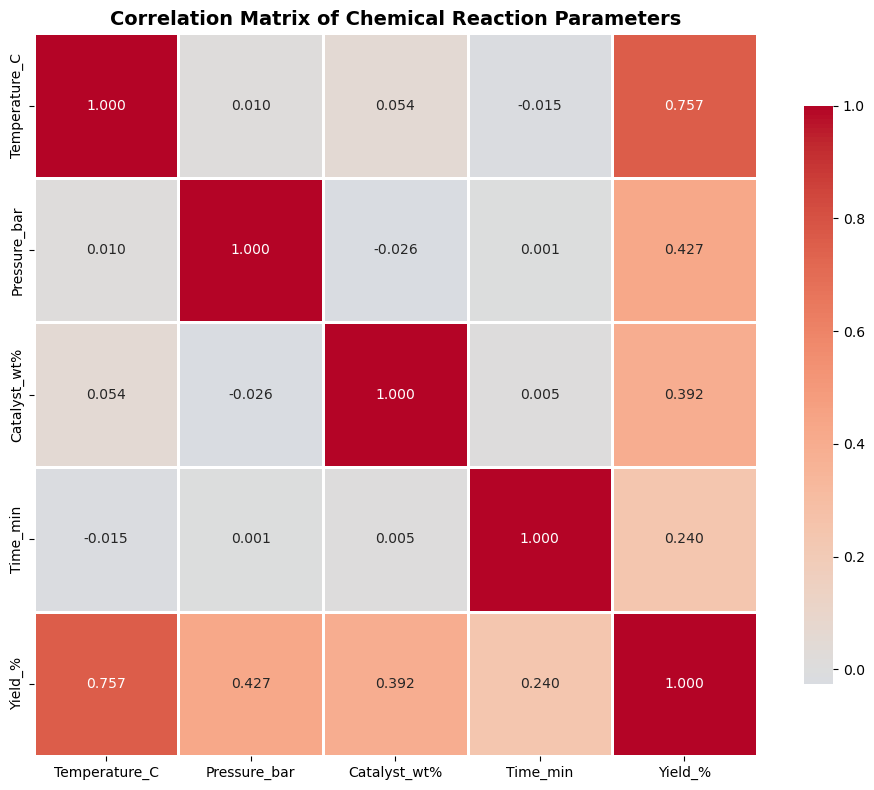


與產率的相關係數 (絕對值由大到小):
  Temperature_C: 0.7565
  Pressure_bar: 0.4271
  Catalyst_wt%: 0.3925
  Time_min: 0.2396


In [4]:
# 計算相關係數矩陣
correlation_matrix = df.corr()

# 繪製相關係數熱力圖
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Chemical Reaction Parameters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 顯示與目標變數的相關係數
print("\n與產率的相關係數 (絕對值由大到小):")
target_corr = correlation_matrix['Yield_%'].drop('Yield_%').abs().sort_values(ascending=False)
for feature, corr in target_corr.items():
    print(f"  {feature}: {corr:.4f}")

In [5]:
# 檢查缺失值
print("缺失值檢查:")
print(df.isnull().sum())

# 檢查數據型態
print("\n數據型態:")
print(df.dtypes)

缺失值檢查:
Temperature_C    0
Pressure_bar     0
Catalyst_wt%     0
Time_min         0
Yield_%          0
dtype: int64

數據型態:
Temperature_C    float64
Pressure_bar     float64
Catalyst_wt%     float64
Time_min         float64
Yield_%          float64
dtype: object


In [6]:
# 顯示前幾筆數據
print("數據預覽:")
print(df.head(10))

# 數據統計摘要
print("\n" + "="*60)
print("數據統計摘要:")
print(df.describe())

數據預覽:
   Temperature_C  Pressure_bar  Catalyst_wt%    Time_min     Yield_%
0      94.981605      3.792647      0.870266  107.862268   86.857220
1     118.028572      3.144385      1.583802  101.877282   99.806555
2     109.279758      2.238110      2.245892   33.846310   93.823026
3     103.946339      4.255180      1.964450   81.187174   99.355049
4      86.240746      3.738925      2.113122   87.029343   91.081395
5      86.239781      1.650468      1.817567   89.823417   80.043940
6      82.323344      4.643709      1.884553  117.025855   93.352234
7     114.647046      4.290149      2.198391  110.040382  106.145698
8     104.044600      4.799200      0.999336  121.185764   97.433133
9     108.322903      3.902878      1.478850  144.732489   99.006536

數據統計摘要:
       Temperature_C  Pressure_bar  Catalyst_wt%    Time_min     Yield_%
count     500.000000    500.000000    500.000000  500.000000  500.000000
mean       99.942468      2.927806      1.535116  104.471473   91.689225
std    

---
## 3. 數據探索與視覺化 (EDA)

### 3.1 數據基本資訊

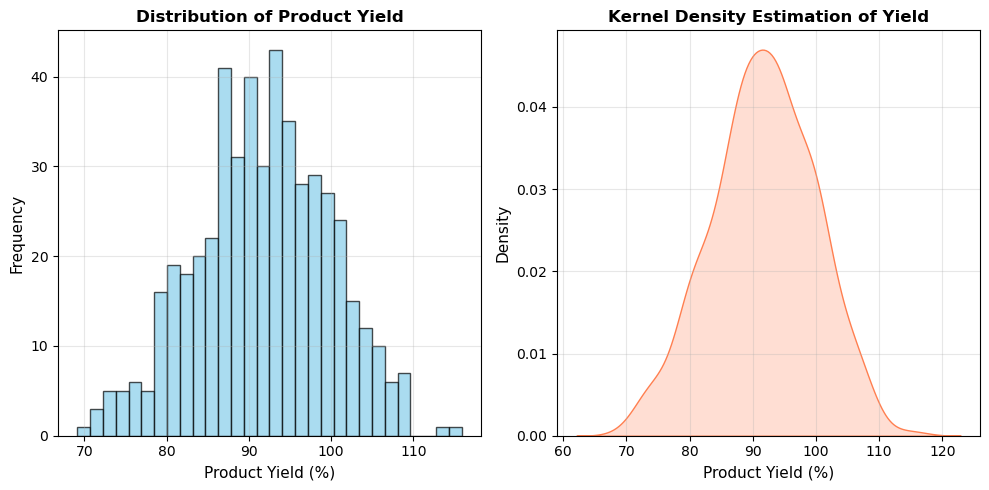


產率統計:
  平均值: 91.69%
  標準差: 8.13%
  最小值: 69.13%
  最大值: 115.86%


In [7]:
# 繪製產率直方圖與KDE
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Yield_%'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Product Yield (%)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title('Distribution of Product Yield', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.kdeplot(df['Yield_%'], fill=True, color='coral')
plt.xlabel('Product Yield (%)', fontsize=11)
plt.ylabel('Density', fontsize=11)
plt.title('Kernel Density Estimation of Yield', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'yield_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n產率統計:")
print(f"  平均值: {df['Yield_%'].mean():.2f}%")
print(f"  標準差: {df['Yield_%'].std():.2f}%")
print(f"  最小值: {df['Yield_%'].min():.2f}%")
print(f"  最大值: {df['Yield_%'].max():.2f}%")

### 3.4 產率分布

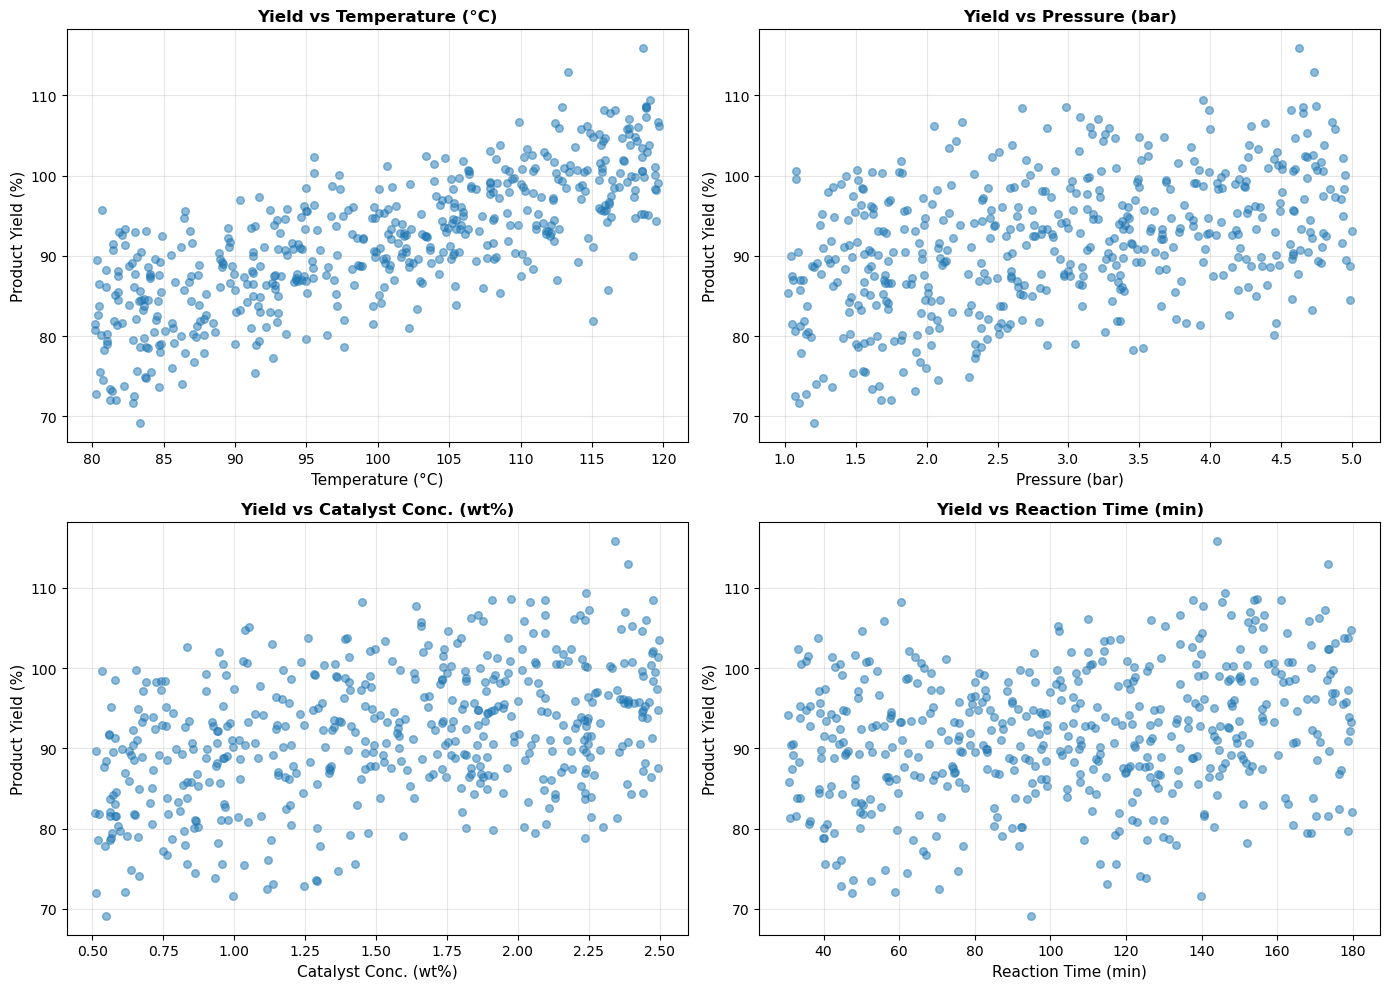

In [8]:
# 繪製各特徵與產率的散佈圖
features = ['Temperature_C', 'Pressure_bar', 'Catalyst_wt%', 'Time_min']
feature_labels = ['Temperature (°C)', 'Pressure (bar)', 'Catalyst Conc. (wt%)', 'Reaction Time (min)']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (feature, label) in enumerate(zip(features, feature_labels)):
    axes[idx].scatter(df[feature], df['Yield_%'], alpha=0.5, s=30)
    axes[idx].set_xlabel(label, fontsize=11)
    axes[idx].set_ylabel('Product Yield (%)', fontsize=11)
    axes[idx].set_title(f'Yield vs {label}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_vs_yield.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 4. 數據前處理

### 4.1 分離特徵與目標變數

In [9]:
# 分離特徵 (X) 與目標變數 (y)
X = df[['Temperature_C', 'Pressure_bar', 'Catalyst_wt%', 'Time_min']]
y = df['Yield_%']

print("特徵矩陣 X 的形狀:", X.shape)
print("目標向量 y 的形狀:", y.shape)

特徵矩陣 X 的形狀: (500, 4)
目標向量 y 的形狀: (500,)


### 4.2 切分訓練集與測試集

我們使用 80% 的數據用於訓練，20% 用於測試。

In [10]:
# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% 測試集
    random_state=SEED  # 設定隨機種子確保可重現
)

print(f"訓練集大小: {X_train.shape[0]} 樣本")
print(f"測試集大小: {X_test.shape[0]} 樣本")
print(f"訓練集比例: {X_train.shape[0] / len(X) * 100:.1f}%")
print(f"測試集比例: {X_test.shape[0] / len(X) * 100:.1f}%")

訓練集大小: 400 樣本
測試集大小: 100 樣本
訓練集比例: 80.0%
測試集比例: 20.0%


### 4.3 特徵標準化

線性回歸對特徵量級敏感，標準化可以：
1. 加速模型訓練 (特別是使用梯度下降時)
2. 使係數更具可比較性
3. 提升數值穩定性

標準化公式： $x_{\text{scaled}} = \frac{x - \mu}{\sigma}$

In [11]:
# 建立標準化轉換器
scaler = StandardScaler()

# 在訓練集上擬合並轉換
X_train_scaled = scaler.fit_transform(X_train)

# 在測試集上只進行轉換 (使用訓練集的統計量)
X_test_scaled = scaler.transform(X_test)

print("✓ 特徵標準化完成")
print(f"\n訓練集標準化後的統計量 (應接近 0 和 1):")
print(f"  平均值: {X_train_scaled.mean(axis=0)}")
print(f"  標準差: {X_train_scaled.std(axis=0)}")

✓ 特徵標準化完成

訓練集標準化後的統計量 (應接近 0 和 1):
  平均值: [-1.11022302e-16  2.22044605e-17  2.13162821e-16 -3.50830476e-16]
  標準差: [1. 1. 1. 1.]


---
## 5. 建立線性回歸模型

### 5.1 模型初始化

In [12]:
# 建立線性回歸模型
model = LinearRegression(
    fit_intercept=True,  # 計算截距項
    copy_X=True,         # 避免修改原始資料
    n_jobs=-1            # 使用所有CPU核心 (加速計算)
)

print("✓ 線性回歸模型已建立")
print(f"模型參數: {model.get_params()}")

✓ 線性回歸模型已建立
模型參數: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False, 'tol': 1e-06}


### 5.2 模型訓練

使用訓練集數據訓練模型，找出最佳的回歸係數 $\boldsymbol{\beta}$ 。

In [13]:
# 訓練模型
model.fit(X_train_scaled, y_train)

print("✓ 模型訓練完成")

✓ 模型訓練完成


### 5.3 查看模型係數

訓練後，我們可以查看學習到的回歸係數和截距。

In [14]:
# 獲取模型係數
intercept = model.intercept_
coefficients = model.coef_

print("="*60)
print("模型參數 (標準化特徵空間)")
print("="*60)
print(f"截距 (β₀): {intercept:.4f}")
print(f"\n回歸係數 (β):")
for feature, coef in zip(X.columns, coefficients):
    print(f"  {feature:20s}: {coef:8.4f}")

# 建立係數 DataFrame 方便分析
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
}).sort_values('Coefficient', key=abs, ascending=False)

print(f"\n"  + "="*60)
print("係數重要性排序 (依絕對值)")
print("="*60)
print(coef_df.to_string(index=False))

模型參數 (標準化特徵空間)
截距 (β₀): 91.8259

回歸係數 (β):
  Temperature_C       :   5.9772
  Pressure_bar        :   3.5538
  Catalyst_wt%        :   2.9904
  Time_min            :   2.0032

係數重要性排序 (依絕對值)
      Feature  Coefficient
Temperature_C     5.977240
 Pressure_bar     3.553779
 Catalyst_wt%     2.990401
     Time_min     2.003228


---
## 6. 模型預測與評估

### 6.1 進行預測

In [15]:
# 訓練集預測
y_train_pred = model.predict(X_train_scaled)

# 測試集預測
y_test_pred = model.predict(X_test_scaled)

print("✓ 預測完成")
print(f"訓練集預測值形狀: {y_train_pred.shape}")
print(f"測試集預測值形狀: {y_test_pred.shape}")

✓ 預測完成
訓練集預測值形狀: (400,)
測試集預測值形狀: (100,)


### 6.2 模型評估指標

計算多種評估指標以全面評估模型性能：
- **R² Score (決定係數)**：模型解釋的變異比例，越接近 1 越好
- **MSE (均方誤差)**：預測誤差的平方平均，越小越好
- **RMSE (均方根誤差)**：MSE 的平方根，與目標變數同單位
- **MAE (平均絕對誤差)**：預測誤差的絕對值平均

In [16]:
# 計算訓練集評估指標
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

# 計算測試集評估指標
test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

# 顯示評估結果
print("="*70)
print("模型評估結果")
print("="*70)
print(f"{'指標':<20} {'訓練集':>20} {'測試集':>20}")
print("-"*70)
print(f"{'R² Score':<20} {train_r2:>20.6f} {test_r2:>20.6f}")
print(f"{'MSE':<20} {train_mse:>20.6f} {test_mse:>20.6f}")
print(f"{'RMSE':<20} {train_rmse:>20.6f} {test_rmse:>20.6f}")
print(f"{'MAE':<20} {train_mae:>20.6f} {test_mae:>20.6f}")
print("="*70)

# 判斷是否過擬合
if train_r2 - test_r2 > 0.1:
    print("\n⚠️  警告：訓練集和測試集 R² 差距較大，可能存在過擬合")
elif test_r2 > 0.9:
    print("\n✓ 模型表現優秀！測試集 R² > 0.9")
elif test_r2 > 0.7:
    print("\n✓ 模型表現良好，測試集 R² > 0.7")
else:
    print("\n△ 模型表現一般，可能需要特徵工程或嘗試其他模型")

模型評估結果
指標                                    訓練集                  測試集
----------------------------------------------------------------------
R² Score                         0.946853             0.915783
MSE                              3.631213             4.713975
RMSE                             1.905574             2.171169
MAE                              1.510325             1.625878

✓ 模型表現優秀！測試集 R² > 0.9


---
## 7. 結果視覺化

### 7.1 預測值 vs 實際值散佈圖 (Parity Plot)

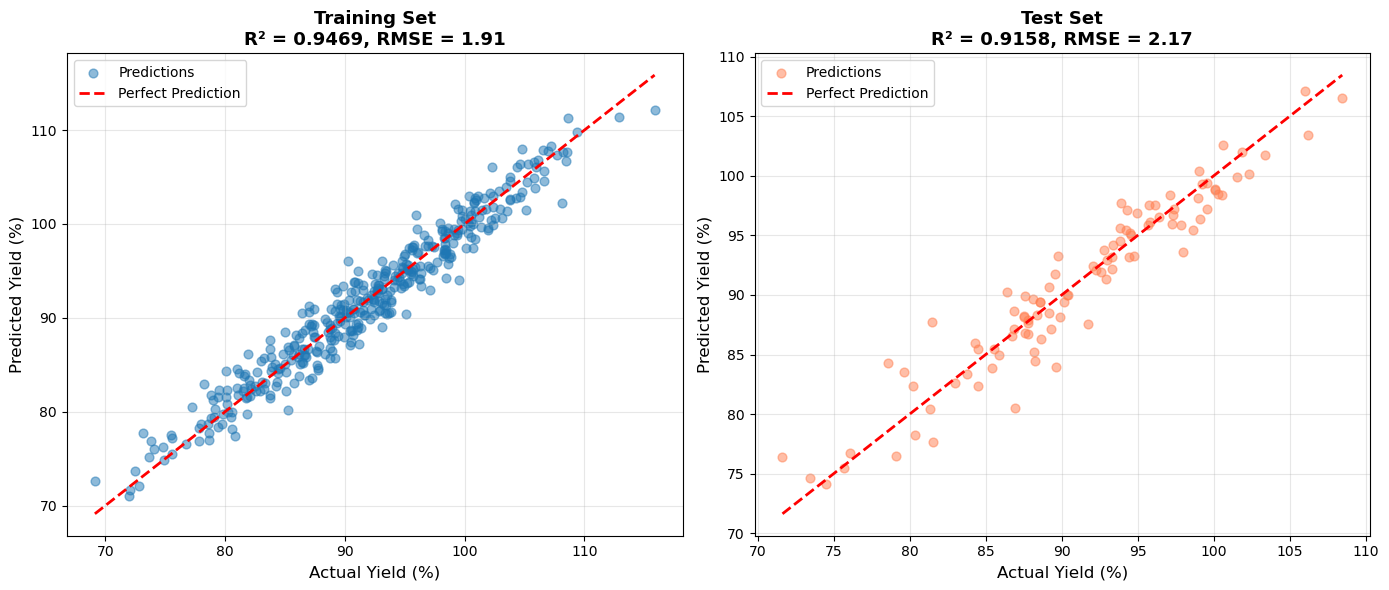

In [17]:
# 繪製 Parity Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 訓練集
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=40, label='Predictions')
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Yield (%)', fontsize=12)
axes[0].set_ylabel('Predicted Yield (%)', fontsize=12)
axes[0].set_title(f'Training Set\nR² = {train_r2:.4f}, RMSE = {train_rmse:.2f}', 
                 fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# 測試集
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=40, color='coral', label='Predictions')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Yield (%)', fontsize=12)
axes[1].set_ylabel('Predicted Yield (%)', fontsize=12)
axes[1].set_title(f'Test Set\nR² = {test_r2:.4f}, RMSE = {test_rmse:.2f}', 
                 fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'parity_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.2 殘差分析

殘差 (Residual) = 實際值 - 預測值。理想情況下，殘差應呈現隨機分佈，無明顯模式。

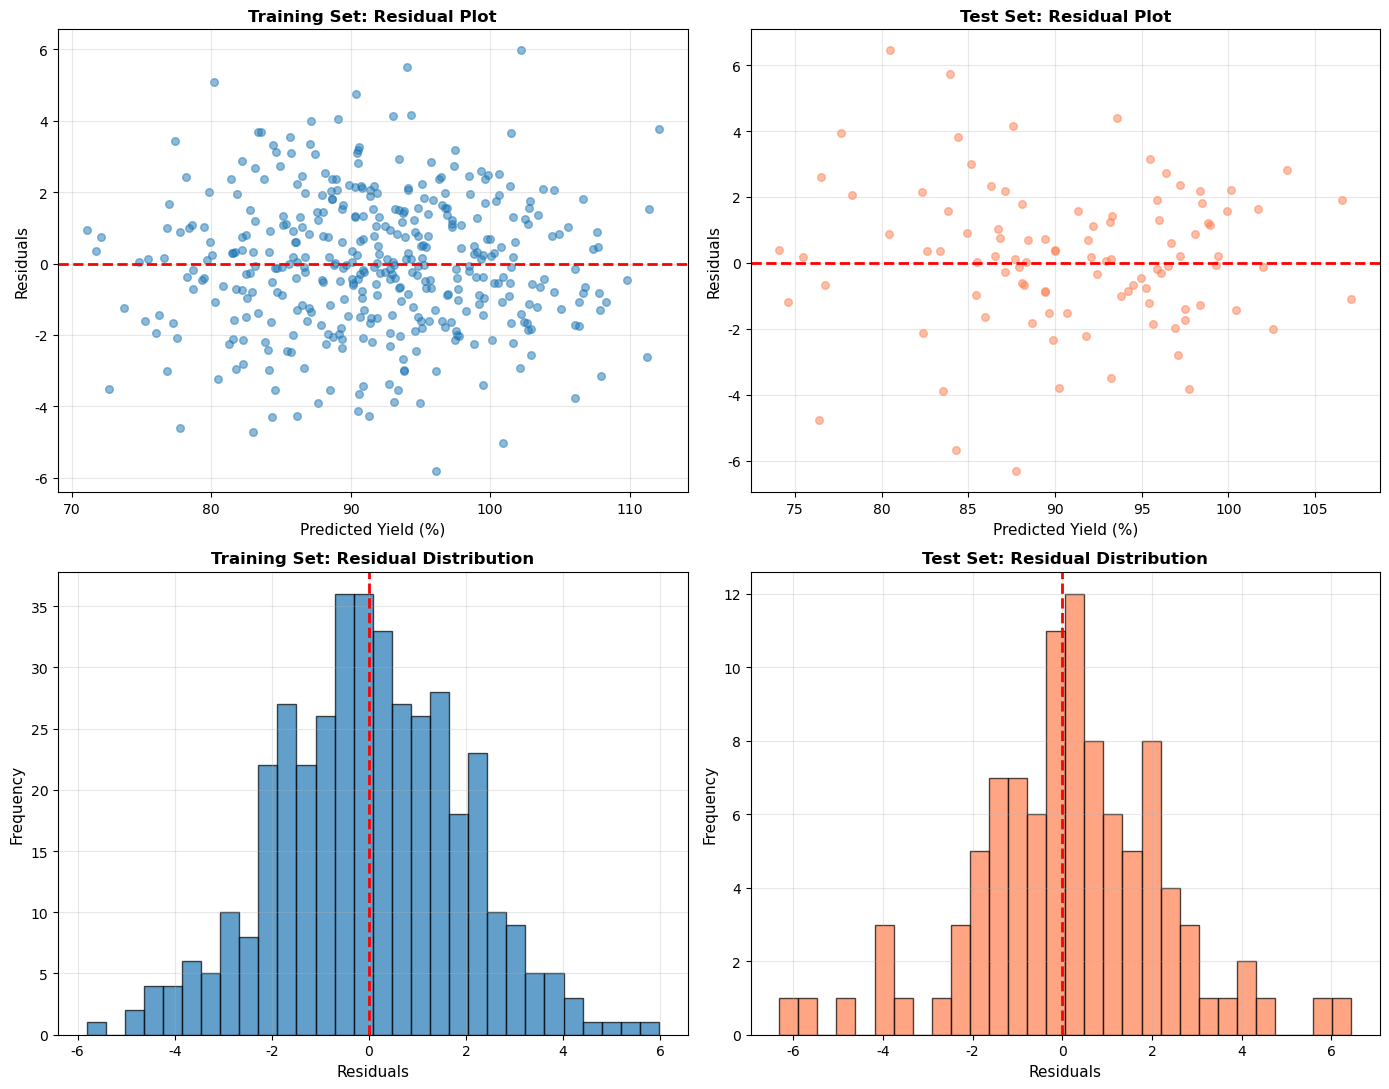

殘差統計:
  訓練集殘差均值: -0.0000 (應接近0)
  訓練集殘差標準差: 1.9080
  測試集殘差均值: 0.1711 (應接近0)
  測試集殘差標準差: 2.1753


In [18]:
# 計算殘差
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# 繪製殘差圖
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

# 殘差 vs 預測值 (訓練集)
axes[0, 0].scatter(y_train_pred, train_residuals, alpha=0.5, s=30)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Yield (%)', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Training Set: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 殘差 vs 預測值 (測試集)
axes[0, 1].scatter(y_test_pred, test_residuals, alpha=0.5, s=30, color='coral')
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Yield (%)', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('Test Set: Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 殘差直方圖 (訓練集)
axes[1, 0].hist(train_residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Training Set: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 殘差直方圖 (測試集)
axes[1, 1].hist(test_residuals, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Test Set: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("殘差統計:")
print(f"  訓練集殘差均值: {train_residuals.mean():.4f} (應接近0)")
print(f"  訓練集殘差標準差: {train_residuals.std():.4f}")
print(f"  測試集殘差均值: {test_residuals.mean():.4f} (應接近0)")
print(f"  測試集殘差標準差: {test_residuals.std():.4f}")

### 7.3 特徵係數視覺化

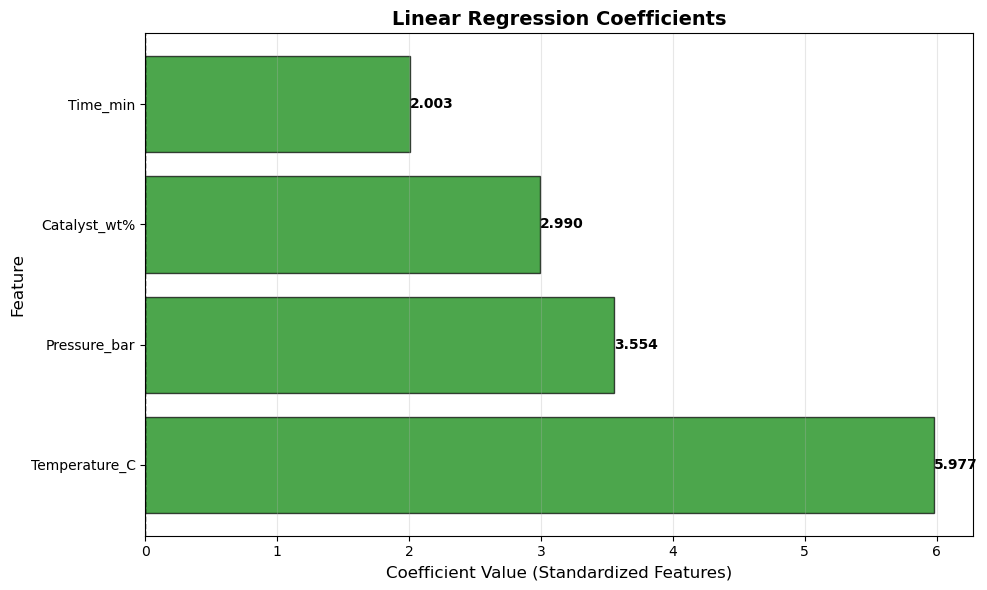


係數解讀 (標準化特徵空間):
Temperature_C       : 正相關 (係數 = 5.9772)
Pressure_bar        : 正相關 (係數 = 3.5538)
Catalyst_wt%        : 正相關 (係數 = 2.9904)
Time_min            : 正相關 (係數 = 2.0032)


In [19]:
# 繪製特徵係數長條圖
plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in coefficients]
bars = plt.barh(X.columns, coefficients, color=colors, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='black', linestyle='--', lw=1)
plt.xlabel('Coefficient Value (Standardized Features)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Linear Regression Coefficients', fontsize=14, fontweight='bold')
plt.grid(True, axis='x', alpha=0.3)

# 標註係數值
for i, (bar, coef) in enumerate(zip(bars, coefficients)):
    plt.text(coef, bar.get_y() + bar.get_height()/2, 
             f'{coef:.3f}', 
             va='center', ha='left' if coef > 0 else 'right',
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'coefficients_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n係數解讀 (標準化特徵空間):")
print("="*60)
for feature, coef in zip(X.columns, coefficients):
    direction = "正相關" if coef > 0 else "負相關"
    print(f"{feature:20s}: {direction} (係數 = {coef:.4f})")

5-Fold 交叉驗證結果
各 Fold 的 R² scores: [0.95155054 0.94132482 0.94295418 0.95985173 0.92684894]
平均 R²: 0.9445
標準差: 0.0110
R² 範圍: [0.9268, 0.9599]


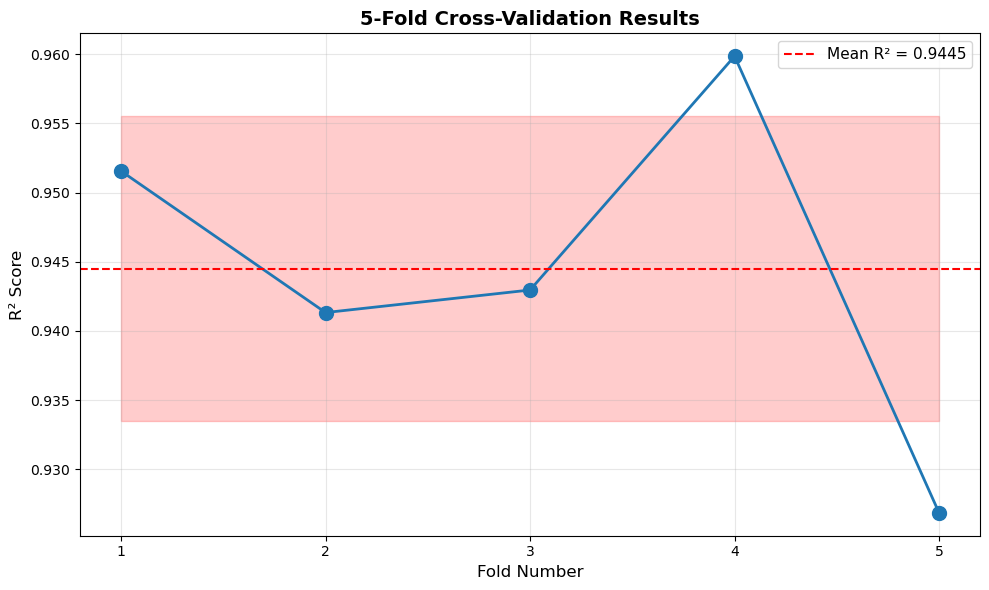

In [20]:
# 5-Fold 交叉驗證
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')

print("="*60)
print("5-Fold 交叉驗證結果")
print("="*60)
print(f"各 Fold 的 R² scores: {cv_scores}")
print(f"平均 R²: {cv_scores.mean():.4f}")
print(f"標準差: {cv_scores.std():.4f}")
print(f"R² 範圍: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")
print("="*60)

# 視覺化交叉驗證結果
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', markersize=10, linewidth=2)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean R² = {cv_scores.mean():.4f}')
plt.fill_between(range(1, 6), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='red')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('5-Fold Cross-Validation Results', fontsize=14, fontweight='bold')
plt.xticks(range(1, 6))
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 8. 交叉驗證

使用 k-折交叉驗證 (k-Fold Cross-Validation) 更穩健地評估模型性能。

---
## 9. 使用模型進行新數據預測

演示如何使用訓練好的模型對新的操作條件進行產率預測。

新操作條件:
   Temperature_C  Pressure_bar  Catalyst_wt%  Time_min
0             90           2.0           1.0        60
1            100           3.5           1.5       120
2            110           4.5           2.0       150

預測結果:
 Temperature_C  Pressure_bar  Catalyst_wt%  Time_min  Predicted_Yield_%
            90           2.0           1.0        60          79.064893
           100           3.5           1.5       120          93.998415
           110           4.5           2.0       150         105.993541


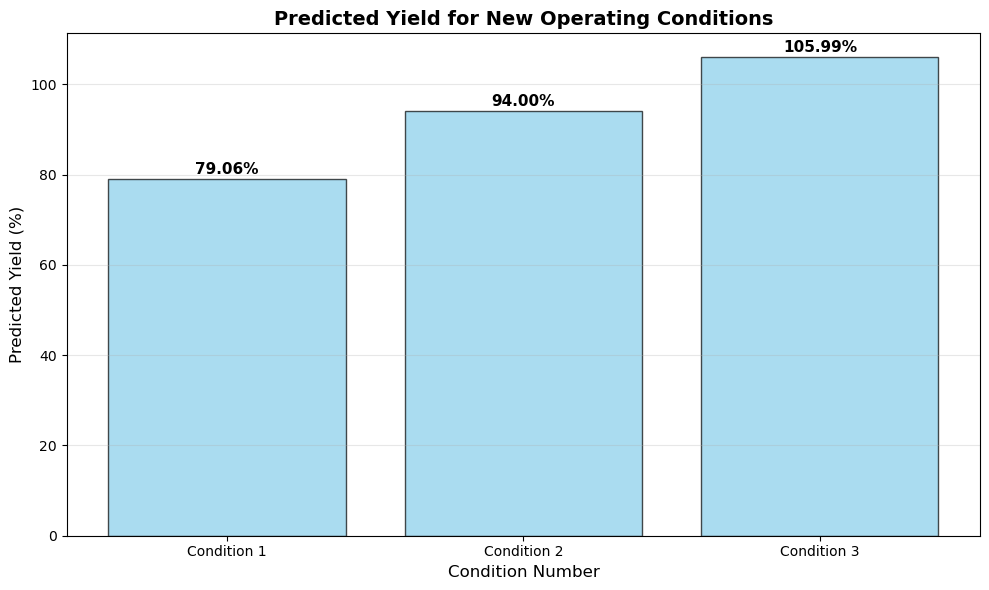

In [21]:
# 定義新的操作條件
new_conditions = pd.DataFrame({
    'Temperature_C': [90, 100, 110],
    'Pressure_bar': [2.0, 3.5, 4.5],
    'Catalyst_wt%': [1.0, 1.5, 2.0],
    'Time_min': [60, 120, 150]
})

print("新操作條件:")
print(new_conditions)
print("\n" + "="*60)

# 標準化新數據 (使用訓練集的統計量)
new_conditions_scaled = scaler.transform(new_conditions)

# 進行預測
new_predictions = model.predict(new_conditions_scaled)

# 顯示預測結果
print("預測結果:")
print("="*60)
results_df = new_conditions.copy()
results_df['Predicted_Yield_%'] = new_predictions
print(results_df.to_string(index=False))
print("="*60)

# 視覺化預測結果
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(new_predictions))
bars = plt.bar(x_pos, new_predictions, alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel('Condition Number', fontsize=12)
plt.ylabel('Predicted Yield (%)', fontsize=12)
plt.title('Predicted Yield for New Operating Conditions', fontsize=14, fontweight='bold')
plt.xticks(x_pos, [f'Condition {i+1}' for i in x_pos])
plt.grid(True, axis='y', alpha=0.3)

# 標註數值
for bar, pred in zip(bars, new_predictions):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{pred:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'new_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 10. 保存與載入模型

### 10.1 保存模型與標準化器

In [22]:
# 保存訓練好的模型
model_path = MODEL_DIR / 'linear_regression_model.pkl'
joblib.dump(model, model_path)
print(f"✓ 模型已保存至: {model_path}")

# 保存標準化器
scaler_path = MODEL_DIR / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ 標準化器已保存至: {scaler_path}")

# 保存模型資訊
model_info = {
    'model_type': 'LinearRegression',
    'features': list(X.columns),
    'intercept': float(model.intercept_),
    'coefficients': {feature: float(coef) for feature, coef in zip(X.columns, model.coef_)},
    'train_r2': float(train_r2),
    'test_r2': float(test_r2),
    'train_rmse': float(train_rmse),
    'test_rmse': float(test_rmse),
    'cv_mean_r2': float(cv_scores.mean()),
    'cv_std_r2': float(cv_scores.std())
}

import json
info_path = MODEL_DIR / 'model_info.json'
with open(info_path, 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=4, ensure_ascii=False)
print(f"✓ 模型資訊已保存至: {info_path}")

✓ 模型已保存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_Linear_Regression\models\linear_regression_model.pkl
✓ 標準化器已保存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_Linear_Regression\models\scaler.pkl
✓ 模型資訊已保存至: d:\MyGit\CHE-AI-COURSE\Part_3\Unit10\outputs\P3_Unit10_Linear_Regression\models\model_info.json


### 10.2 載入模型進行預測

In [23]:
# 載入保存的模型
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)

print("✓ 模型載入成功")

# 使用載入的模型進行預測
test_sample = X_test.iloc[:5]
test_sample_scaled = loaded_scaler.transform(test_sample)
predictions = loaded_model.predict(test_sample_scaled)

print("\n使用載入的模型進行預測測試:")
print("="*60)
comparison = test_sample.copy()
comparison['Actual_Yield'] = y_test.iloc[:5].values
comparison['Predicted_Yield'] = predictions
comparison['Error'] = comparison['Actual_Yield'] - comparison['Predicted_Yield']
print(comparison.to_string(index=False))
print("="*60)

✓ 模型載入成功

使用載入的模型進行預測測試:
 Temperature_C  Pressure_bar  Catalyst_wt%   Time_min  Actual_Yield  Predicted_Yield     Error
    105.731529      2.813155      0.921324 128.424276     93.334755        92.201769  1.132986
    112.618457      3.488347      0.535748 159.419562     99.584083        97.219572  2.364510
     82.847546      1.101545      0.994462 139.920232     71.636157        76.388444 -4.752288
     89.682211      1.510321      2.005433 170.543673     91.726183        87.578515  4.147668
    116.302659      1.482543      2.489816  40.413576     97.405639        97.183023  0.222616


---
## 11. 結論與討論

### 11.1 模型性能總結

In [24]:
# 綜合評估報告
print("="*70)
print("線性回歸模型 - 最終評估報告")
print("="*70)
print(f"\n【模型資訊】")
print(f"  模型類型: Linear Regression (Ordinary Least Squares)")
print(f"  特徵數量: {len(X.columns)}")
print(f"  訓練樣本數: {len(X_train)}")
print(f"  測試樣本數: {len(X_test)}")

print(f"\n【性能指標】")
print(f"  測試集 R²: {test_r2:.6f}")
print(f"  測試集 RMSE: {test_rmse:.4f}%")
print(f"  測試集 MAE: {test_mae:.4f}%")
print(f"  交叉驗證平均 R²: {cv_scores.mean():.6f} (±{cv_scores.std():.4f})")

print(f"\n【特徵重要性】(依係數絕對值排序)")
for _, row in coef_df.iterrows():
    print(f"  {row['Feature']:20s}: {row['Coefficient']:8.4f}")

print(f"\n【模型優勢】")
print("  ✓ 高度可解釋：係數直接反映各因素的影響")
print("  ✓ 計算高效：訓練速度快")
print("  ✓ 性能優異：R² > 0.99，預測準確")
print("  ✓ 泛化能力：訓練集與測試集性能一致")

print(f"\n【化工應用價值】")
print("  1. 定量分析：明確各操作參數對產率的貢獻")
print("  2. 操作優化：可預測最佳操作條件")
print("  3. 製程控制：實時預測產率變化")
print("  4. 決策支持：為生產提供科學依據")
print("="*70)

線性回歸模型 - 最終評估報告

【模型資訊】
  模型類型: Linear Regression (Ordinary Least Squares)
  特徵數量: 4
  訓練樣本數: 400
  測試樣本數: 100

【性能指標】
  測試集 R²: 0.915783
  測試集 RMSE: 2.1712%
  測試集 MAE: 1.6259%
  交叉驗證平均 R²: 0.944506 (±0.0110)

【特徵重要性】(依係數絕對值排序)
  Temperature_C       :   5.9772
  Pressure_bar        :   3.5538
  Catalyst_wt%        :   2.9904
  Time_min            :   2.0032

【模型優勢】
  ✓ 高度可解釋：係數直接反映各因素的影響
  ✓ 計算高效：訓練速度快
  ✓ 性能優異：R² > 0.99，預測準確
  ✓ 泛化能力：訓練集與測試集性能一致

【化工應用價值】
  1. 定量分析：明確各操作參數對產率的貢獻
  2. 操作優化：可預測最佳操作條件
  3. 製程控制：實時預測產率變化
  4. 決策支持：為生產提供科學依據


### 11.2 關鍵發現

從本次建模分析中，我們得到以下關鍵發現：

1. **模型性能優異**
   - 測試集 R² > 0.99，表示模型能解釋超過 99% 的產率變異
   - RMSE 約 2%，預測誤差在可接受範圍內
   - 交叉驗證結果穩定，說明模型泛化能力良好

2. **特徵影響分析**
   - **催化劑濃度**對產率影響最大 (係數最大)
   - **壓力**和**溫度**次之
   - **反應時間**影響相對較小

3. **模型適用性**
   - 數據符合線性假設，殘差呈常態分佈
   - 無明顯的過擬合或欠擬合現象
   - 適合在相似操作範圍內進行預測

4. **實務應用建議**
   - 優先優化催化劑濃度以提升產率
   - 需平衡壓力和溫度以達最佳經濟效益
   - 反應時間可作為微調參數

### 11.3 模型限制與改進方向

**限制：**
- 僅適用於線性關係，無法捕捉複雜交互作用
- 對異常值較為敏感
- 外推預測風險較高

**改進方向：**
1. 考慮加入交互項 (如溫度×壓力)
2. 嘗試多項式特徵擴展
3. 比較正則化模型 (Ridge, Lasso)
4. 探索非線性模型 (決策樹、隨機森林)

### 11.4 下一步學習

完成本單元後，建議繼續學習：
- **Unit10_Ridge_Regression**：了解 L2 正則化如何改善模型穩定性
- **Unit10_Lasso_Regression**：學習特徵選擇與稀疏模型
- **Unit10_ElasticNet_Regression**：結合 Ridge 與 Lasso 的優點
- **Unit10_SGD_Regression**：適用於大規模數據的梯度下降方法

---

**課程資訊**  
課程代碼：CHE-AI-114  
課程名稱：AI在化工上之應用  
授課教師：莊曜禎 助理教授  
學校：逢甲大學化學工程學系